# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

___

### NETWORK TOPOLOGY

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.

In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [0]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [0]:
class CancerDetection(nn.Module):
  def __init__(self,dataset):
    super(CancerDetection, self).__init__()
    input,_ = dataset[0]
    c,_,_ = input.size()
    self.activation = nn.ReLU()

    self.conv1 = nn.Conv2d(c,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.MaxPool2d(2,2)

    self.conv4 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)
    self.conv6 = nn.MaxPool2d(2,2)

    self.conv7 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 1)
    self.conv8 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)
    self.conv9 = nn.MaxPool2d(2,2)

    self.conv10 = nn.Conv2d(256,512,kernel_size = 3, stride = 1, padding = 1)
    self.conv11 = nn.Conv2d(512,512,kernel_size = 3, stride = 1, padding = 1)
    self.conv12 = nn.MaxPool2d(2,2)

    self.conv13 = nn.Conv2d(512,1024,kernel_size = 3, stride = 1, padding = 1)
    self.conv14 = nn.Conv2d(1024,1024,kernel_size = 3, stride = 1, padding = 1)
    self.conv15 = nn.ConvTranspose2d(1024,512,kernel_size = 2,stride = 2)

    self.conv16 = nn.Conv2d(1024,512,kernel_size = 3, stride = 1, padding = 1)
    self.conv17 = nn.Conv2d(512,512,kernel_size = 3, stride = 1, padding = 1)
    self.conv18 = nn.ConvTranspose2d(512,256,kernel_size = 2,stride = 2)

    self.conv19 = nn.Conv2d(512,256,kernel_size = 3, stride = 1, padding = 1)
    self.conv20 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)
    self.conv21 = nn.ConvTranspose2d(256,128,kernel_size = 2,stride = 2)

    self.conv22 = nn.Conv2d(256,128,kernel_size = 3, stride = 1, padding = 1)
    self.conv23 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)
    self.conv24 = nn.ConvTranspose2d(128,64,kernel_size = 2,stride = 2)

    self.conv25 = nn.Conv2d(128,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv26 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv27 = nn.Conv2d(64,2,kernel_size = 1, stride = 1, padding = 0)

  def forward(self, input):
    conv1_out = self.activation(self.conv1(input))
    conv2_out = self.activation(self.conv2(conv1_out))
    conv3_out = (self.conv3(conv2_out))


    conv4_out = self.activation(self.conv4(conv3_out))
    conv5_out = self.activation(self.conv5(conv4_out))
    conv6_out = (self.conv6(conv5_out))


    conv7_out = self.activation(self.conv7(conv6_out))
    conv8_out = self.activation(self.conv8(conv7_out))
    conv9_out = (self.conv9(conv8_out))


    conv10_out = self.activation(self.conv10(conv9_out))
    conv11_out = self.activation(self.conv11(conv10_out))
    conv12_out = (self.conv12(conv11_out))


    conv13_out = self.activation(self.conv13(conv12_out))
    conv14_out = self.activation(self.conv14(conv13_out))
    conv15_out = (self.conv15(conv14_out))
    COPY4 = torch.cat((conv15_out,conv11_out),1)


    conv16_out = self.activation(self.conv16(COPY4))
    conv17_out = self.activation(self.conv17(conv16_out))
    conv18_out = (self.conv18(conv17_out))
    COPY3 = torch.cat((conv18_out,conv8_out),1)


    conv19_out = self.activation(self.conv19(COPY3))
    conv20_out = self.activation(self.conv20(conv19_out))    
    conv21_out = (self.conv21(conv20_out))
    COPY2 = torch.cat((conv21_out,conv5_out),1)


    conv22_out = self.activation(self.conv22(COPY2))
    conv23_out = self.activation(self.conv23(conv22_out))
    conv24_out = (self.conv24(conv23_out))
    COPY1 = torch.cat((conv24_out,conv2_out),1)


    conv25_out = self.activation(self.conv25(COPY1))
    conv26_out = self.activation(self.conv26(conv25_out))
    conv27_out = (self.conv27(conv26_out))

    return conv27_out


In [9]:
losses = []
valid_losses = []
accuracy_list = []
v_accuracy_list = []
def scope():
  try:
    gc.collect()
    print(torch.cuda.memory_allocated(0) / 1e9)
    
    train_dataset = CancerDataset('/top/cancer',train = True)
    valid_dataset = CancerDataset('/top/cancer',train = False)
    model = CancerDetection(train_dataset)
    model = model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    train_loader = DataLoader(train_dataset,
                              batch_size=3,
                              shuffle = True,
                              pin_memory = True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=3,
                              pin_memory = True)
    
    for epoch in range(1):
        loop = tqdm(total=len(train_loader), position = 0, )
        for batch,train in enumerate(train_loader):
            x, y_truth = train
            x, y_truth = x.cuda(async = True), y_truth.cuda(async = True)
            
            optimizer.zero_grad()

            y_hat = model(x)
            
            accuracy = ((torch.softmax(y_hat,1).argmax(1)== y_truth).float()).mean()
            accuracy_list.append(accuracy)
            
            loss = objective(y_hat, y_truth.long())

            loop.set_description("epoch # "+str(epoch)+' loss:{:.4f}'.format(loss.item()))
            loop.update(1)

            loss.backward()

            optimizer.step()

            losses.append(loss)

            if batch % 20 == 0:
                val = np.mean([objective(model(x.cuda()),y.long().cuda()).item() for x, y in valid_loader])
                valid_losses.append(val)
                v_accuracy = torch.mean((torch.stack([((model(x.cuda()).argmax(1) == y.cuda()).float()).mean() for x,y in valid_loader])))
                v_accuracy_list.append(v_accuracy)
        loop.close()
    return model
  except:
    __ITB__()
    
model = scope()


0.0


epoch # 0 loss:0.1426: 100%|██████████| 448/448 [26:43<00:00,  2.64s/it]


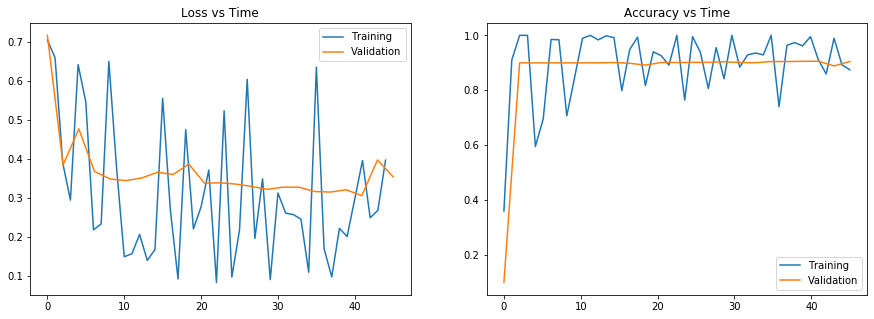

In [10]:
# Your plotting code here
plt.figure(figsize = (15,5))
plt.subplot(121)
y1 = losses
plt.plot(np.arange(len(y1[::10])),y1[::10], label = "Training")
y2 = valid_losses
plt.plot(np.linspace(0,len(y1[::10]),len(y2)),y2,label = "Validation")
plt.title("Loss vs Time")
plt.legend()
plt.subplot(122)
y3 = v_accuracy_list
y4 = accuracy_list
plt.plot(np.linspace(0,len(y1[::10]),len(y4[::10])),y4[::10],label = "Training")
plt.plot(np.linspace(0,len(y1[::10]),len(y3)),y3,label = "Validation")
plt.title("Accuracy vs Time")
plt.legend()
_ = plt.show()

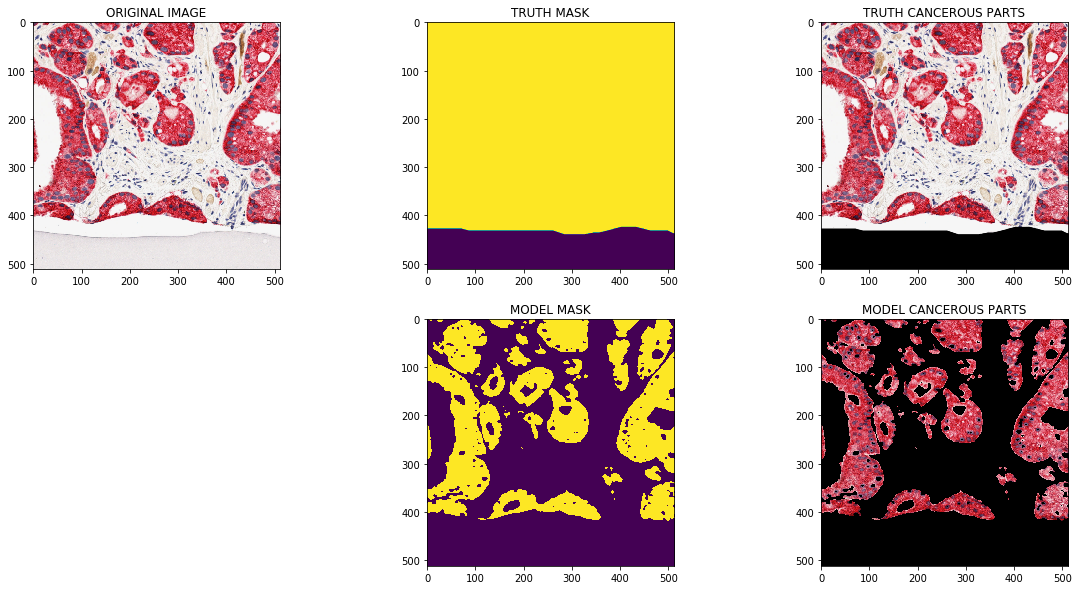

In [31]:
# Code for testing prediction on an image
train_dataset = CancerDataset('/top/cancer',train = True)
train_loader = DataLoader(train_dataset,
                              batch_size=4,
                              shuffle = True,
                              pin_memory = True)

gc.collect()
for train in train_loader:
  plt.figure(figsize = (20,10))
  im = torch.transpose(train[0][0,:,:,:], 0,2)
  plt.subplot(2,3,1)
  plt.title("ORIGINAL IMAGE")
  plt.imshow(im)
  im1 = train[1][0,:,:]
  plt.subplot(2,3,2)
  plt.title("TRUTH MASK")
  plt.imshow(im1.T)
  plt.subplot(2,3,3)
  plt.title("TRUTH CANCEROUS PARTS")
  plt.imshow(np.array(im)*np.array(im1.T)[:,:,np.newaxis])
  plt.subplot(235)
  plt.title("MODEL MASK")
  y_hat = model(train[0].cuda())[0][0]>0
  im2 = y_hat.cpu()
  plt.imshow(~im2.T) 
  plt.subplot(236)
  plt.title("MODEL CANCEROUS PARTS")
  plt.imshow(np.array(im)*np.array(~im2.T)[:,:,np.newaxis])
  break